In [1]:
import re
import pandas as pd
import numpy as np
import funcs 
import importlib
import unicodecsv as csv
import pickle
import random
import gensim
from gensim import corpora, models
from timeit import default_timer as timer
from datetime import datetime, timedelta
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import spacy
from collections import Counter
import pyLDAvis
import pyLDAvis.gensim
from sklearn.model_selection import train_test_split
import scipy
from sklearn.decomposition import PCA
%matplotlib inline
importlib.reload(funcs)

<module 'funcs' from 'D:\\_projekty\\praca\\funcs.py'>

## Wgranie pickli z embeddingami

In [2]:
NAWL_vec_dict = pickle.load(open('nawl.p', 'rb'))
corp_vec_dict = pickle.load(open('corp_vec.p', 'rb'))
df_sp = pickle.load(open('df_sp.p', 'rb'))

In [3]:
df_sp.head()


,word,counter,category,mean Happiness,mean Anger,mean Sadness,mean Fear,mean Disgust,distance to H,distance to A,distance to S,distance to F,distance to D,new_flag
0,chcieć,205353,H,4.333334,1.777778,2.037037,2.148148,1.592593,4.030499,7.033235,6.847620,6.729651,7.201385,H
1,zdanie,46410,H,2.962963,1.222222,1.185185,1.444444,1.148148,4.453825,6.560185,6.583048,6.347609,6.579155,H
2,powiedzieć,114946,U,3.000000,1.346154,1.538462,2.307692,1.192308,5.129413,6.853925,6.679800,5.946053,6.967851,H
3,temat,36539,NaN,NaN,NaN,NaN,NaN,NaN,5.184716,6.608413,6.695697,6.035651,6.846346,H
4,skutek,31434,NaN,NaN,NaN,NaN,NaN,NaN,4.623716,6.783997,6.879018,6.202185,7.055279,H


In [3]:
df_sp[df_sp.counter>=10].groupby('new_flag')['new_flag'].count()

#new_flag
#A      2002
#D      1146
#F      4215
#H    103541
#S      1663
#Name: new_flag, dtype: int64

new_flag
A      884
D      280
F     1141
H    28872
S      310
Name: new_flag, dtype: int64

## Analiza PCA wszystkich grup

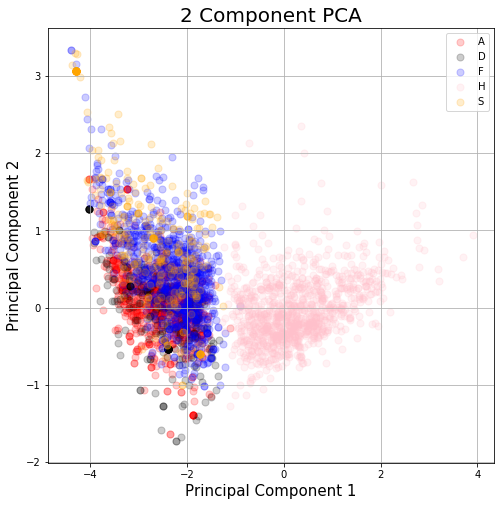

In [14]:
df = df_sp.loc[(pd.isnull(df_sp.new_flag)==False) & (df_sp.counter>=10)]
df = df.reset_index().drop('index', axis=1)
pca = PCA(n_components=2)
PCA_w = pca.fit_transform(df[['distance to H','distance to A','distance to S','distance to F','distance to D']])
principalDf = pd.DataFrame(data = PCA_w
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df['new_flag']], axis = 1)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = ['A', 'D', 'F', 'H', 'S']
colors = ['r', 'black', 'b', 'pink', 'orange']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['new_flag'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'][:1000]
               , finalDf.loc[indicesToKeep, 'principal component 2'][:1000]
               , c = color
               , s = 50, alpha=0.2)
ax.legend(targets)
ax.grid()

## Analiza bez największesz grupy - happines

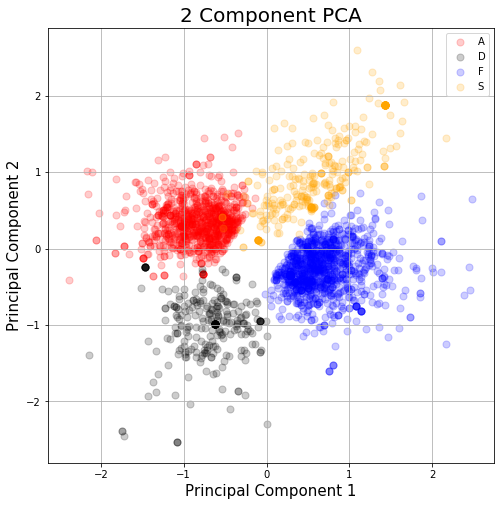

In [16]:
df = df_sp.loc[(pd.isnull(df_sp.new_flag)==False) & (df_sp.new_flag!='H') & (df_sp.counter>=10)]
df = df.reset_index().drop('index', axis=1)
pca = PCA(n_components=2)
PCA_w = pca.fit_transform(df[['distance to A','distance to S','distance to F','distance to D']])
principalDf = pd.DataFrame(data = PCA_w
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df['new_flag']], axis = 1)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = ['A', 'D', 'F', 'S']
colors = ['r', 'black', 'b', 'orange']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['new_flag'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'][:10000]
               , finalDf.loc[indicesToKeep, 'principal component 2'][:10000]
               , c = color
               , s = 50, alpha=0.2)
ax.legend(targets)
ax.grid()

### Poniżej rozbite na kroki

In [7]:
df = df_sp.loc[(pd.isnull(df_sp.new_flag)==False) & (df_sp.new_flag!='H') & (df_sp.counter>=10)]
df = df.reset_index().drop('index', axis=1)
df.tail()

,word,counter,category,mean Happiness,mean Anger,mean Sadness,mean Fear,mean Disgust,distance to H,distance to A,distance to S,distance to F,distance to D,new_flag
2610,bolt,18,NaN,NaN,NaN,NaN,NaN,NaN,6.689267,6.875702,6.981504,5.802686,7.016425,F
2611,wolszlegier,39,NaN,NaN,NaN,NaN,NaN,NaN,6.740568,6.656788,6.800698,5.530938,6.755046,F
2612,taser,11,NaN,NaN,NaN,NaN,NaN,NaN,7.577605,6.653139,7.321512,6.009662,7.283483,F
2613,poldok,12,NaN,NaN,NaN,NaN,NaN,NaN,7.623043,7.311301,7.351387,6.361555,5.677571,D
2614,stirin,12,NaN,NaN,NaN,NaN,NaN,NaN,6.825337,6.845275,6.833293,6.102725,6.693664,F


In [8]:
pca = PCA(n_components=2)
PCA_w = pca.fit_transform(df[['distance to A','distance to S','distance to F','distance to D']])

In [9]:
principalDf = pd.DataFrame(data = PCA_w
             , columns = ['principal component 1', 'principal component 2'])

In [10]:
principalDf.tail()

,principal component 1,principal component 2
2610,0.605772,-0.304664
2611,0.536157,-0.485942
2612,0.403284,-0.118722
2613,-0.080708,-1.348822
2614,0.287238,-0.350379


In [11]:
finalDf = pd.concat([principalDf, df['new_flag']], axis = 1)
finalDf.tail(5)

,principal component 1,principal component 2,new_flag
2610,0.605772,-0.304664,F
2611,0.536157,-0.485942,F
2612,0.403284,-0.118722,F
2613,-0.080708,-1.348822,D
2614,0.287238,-0.350379,F


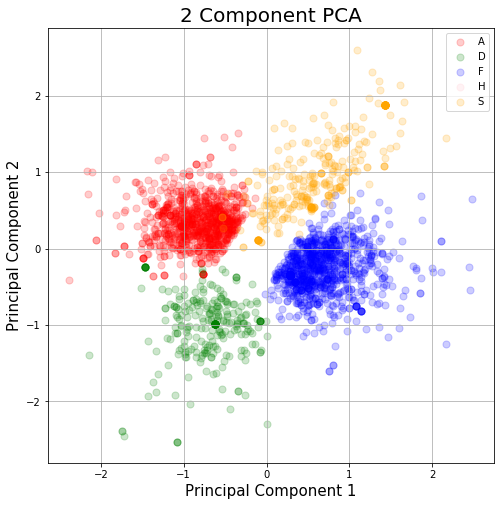

In [12]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = ['A', 'D', 'F', 'H', 'S']
colors = ['r', 'g', 'b', 'pink', 'orange']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['new_flag'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'][:1000]
               , finalDf.loc[indicesToKeep, 'principal component 2'][:1000]
               , c = color
               , s = 50, alpha=0.2)
ax.legend(targets)
ax.grid()

In [27]:
df_sp[(df_sp.new_flag=='H') & (df_sp.counter>=20) & (df_sp['distance to H']<4 )].sort_values('distance to H', ascending=False)

,word,counter,category,mean Happiness,mean Anger,mean Sadness,mean Fear,mean Disgust,distance to H,distance to A,distance to S,distance to F,distance to D,new_flag
46164,wczasowicz,23,NaN,NaN,NaN,NaN,NaN,NaN,3.999982,7.311737,6.723481,7.032993,7.480267,H
59458,niezachwiany,25,NaN,NaN,NaN,NaN,NaN,NaN,3.999832,6.967067,7.078137,6.587419,7.094704,H
19273,przeglądanie,87,NaN,NaN,NaN,NaN,NaN,NaN,3.999799,6.865642,7.132151,6.289918,7.215902,H
32316,członkowstwo,22,NaN,NaN,NaN,NaN,NaN,NaN,3.999745,6.927955,7.107510,6.354617,7.237281,H
12538,dopomóc,379,H,4.500000,2.000000,1.923077,2.076923,1.500000,3.998891,6.906256,7.062052,6.983991,7.468890,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31637,hobby,50,H,6.259259,1.259259,1.148148,1.074074,1.037037,1.102988,7.892230,7.963998,8.029153,8.053188,H
11441,szczęśliwy,918,H,6.500000,1.269231,1.384615,1.423077,1.153846,1.101389,8.176884,8.086461,8.066401,8.271591,H
18229,uśmiech,372,H,6.333334,1.074074,1.296296,1.259259,1.111111,1.016740,8.100848,7.925011,7.938565,8.076864,H
1562,szczęście,3360,H,6.740741,1.148148,1.296296,1.407407,1.000000,0.792897,8.418063,8.338819,8.256472,8.537487,H


# Jak opisać wypowiedź

In [9]:
df_sp_10 = df_sp[(pd.isnull(df_sp.new_flag)==False) & (df_sp.counter>=20)]

In [12]:
df_sp_10.size

329070

In [13]:
pickle.dump(df_sp_10, open('df_ap_10.p', 'wb'))

In [4]:
%time dane = pd.read_csv('00_dane/dane_cleanest.csv',  sep='|', encoding='UTF-8')
%time dane['speech_rawest'] = dane['speech_rawest'].apply(lambda x: re.sub(r'[\W\d]',' ', x))
%time dane['speech_rawest'] = dane['speech_rawest'].apply(lambda x: [word for word in x.split()])


Wall time: 21.3 s
Wall time: 49.4 s
Wall time: 11.5 s


In [5]:
dane.head()

,nr,date_,speech_rawer,full_name,party_final,speech_rawest,topic_LDA_BOW,topic_LDA_TF,opis_LDA_BOW,opis_LDA_TF
0,0,01-02-1992,Chciałbym kilka zdań powiedzieć na temat skut...,Aleksander Bentkowski,Polskie Stronnictwo Ludowe,"[chcieć, zdanie, powiedzieć, temat, skutek, us...",16.0,13.0,wymiar sprawiedliwości,przepisy
1,1,01-02-1992,"Przysłuchując się tej bardzo emocjonalnej, dł...",Aleksander Kwaśniewski,Sojusz Lewicy Demokratycznej,"[przysłuchiwać, emocjonalny, długo, trwać, deb...",14.0,16.0,ustrój państwa,ustrój państwa
2,2,01-02-1992,"Różne przebyliśmy drogi, żeby tu dzisiaj powi...",Alojzy Pietrzyk,Klub Parlamentarny NSZZ Solidarność,"[różny, przebyć, droga, powiedzieć, swój, ocze...",14.0,0.0,ustrój państwa,polityka
3,3,01-02-1992,"Wszystkim nam bardzo zależy na tym, aby urato...",Alojzy Szablewski,Klub Parlamentarny Zjednoczenia Chrześcijańsko...,"[wszystek, zależeć, uratować, przemysł, stocze...",10.0,5.0,NaN,przedsiębiorstwa
4,4,01-02-1992,Z brzmienia pkt. 1 projektu uchwały odczytuję...,Andrzej Baraniecki,Sojusz Lewicy Demokratycznej,"[brzmię, punkt, projekt, uchwała, odczytować, ...",10.0,16.0,NaN,ustrój państwa


In [7]:
len(dane.speech_rawest[0])

463

In [54]:
pd.Series(dane.speech_rawest[0], name='word')

0          chcieć
1          zdanie
2      powiedzieć
3           temat
4          skutek
          ...    
458    roszczenie
459       cywilny
460         tytuł
461      stosunek
462         praca
Name: word, Length: 463, dtype: object

In [78]:
a = pd.merge(pd.Series(dane.speech_rawest[2], name='word'), df_sp_10[['word', 'new_flag']][df_sp_10.new_flag!='H'], 'left', on='word')

In [79]:
z = a.groupby('new_flag').agg(liczba = ('word', 'count'))

In [98]:
z.sort_values(by='liczba', ascending=False).reset_index()['new_flag'][0]

'F'

In [107]:
dane.reset_index().drop('index', axis=1)

,nr,date_,speech_rawer,full_name,party_final,speech_rawest,topic_LDA_BOW,topic_LDA_TF,opis_LDA_BOW,opis_LDA_TF,sentyment
0,0,01-02-1992,Chciałbym kilka zdań powiedzieć na temat skut...,Aleksander Bentkowski,Polskie Stronnictwo Ludowe,"[chcieć, zdanie, powiedzieć, temat, skutek, us...",16.0,13.0,wymiar sprawiedliwości,przepisy,F
1,1,01-02-1992,"Przysłuchując się tej bardzo emocjonalnej, dł...",Aleksander Kwaśniewski,Sojusz Lewicy Demokratycznej,"[przysłuchiwać, emocjonalny, długo, trwać, deb...",14.0,16.0,ustrój państwa,ustrój państwa,A
2,2,01-02-1992,"Różne przebyliśmy drogi, żeby tu dzisiaj powi...",Alojzy Pietrzyk,Klub Parlamentarny NSZZ Solidarność,"[różny, przebyć, droga, powiedzieć, swój, ocze...",14.0,0.0,ustrój państwa,polityka,F
3,3,01-02-1992,"Wszystkim nam bardzo zależy na tym, aby urato...",Alojzy Szablewski,Klub Parlamentarny Zjednoczenia Chrześcijańsko...,"[wszystek, zależeć, uratować, przemysł, stocze...",10.0,5.0,NaN,przedsiębiorstwa,A
4,4,01-02-1992,Z brzmienia pkt. 1 projektu uchwały odczytuję...,Andrzej Baraniecki,Sojusz Lewicy Demokratycznej,"[brzmię, punkt, projekt, uchwała, odczytować, ...",10.0,16.0,NaN,ustrój państwa,A
...,...,...,...,...,...,...,...,...,...,...,...
158315,158874,31-08-2011,Sojuszowi Lewicy Demokratycznej bardzo zależy...,Romuald Ajchler,Sojusz Lewicy Demokratycznej,"[sojusz, lewica, demokratyczny, zależeć, ziemi...",26.0,8.0,posiedzenie,posiedzenie,
158316,158875,31-08-2011,Panie Przewodniczący Krajowej Rady Sądownictw...,Stanisław Rydzoń,Sojusz Lewicy Demokratycznej,"[przewodniczący, krajowy, rada, sądownictwo, z...",16.0,13.0,wymiar sprawiedliwości,przepisy,
158317,158876,31-08-2011,Mam pytanie do pana ministra. Panie ministrze...,Stanisław Rydzoń,Sojusz Lewicy Demokratycznej,"[mieć, pytanie, minister, minister, mieć, doty...",28.0,2.0,handel,inwestycje,
158318,158877,31-08-2011,Pani Minister! Bardzo dużo mówi się o szkolni...,Stanisław Stec,Sojusz Lewicy Demokratycznej,"[minister, mówić, szkolnictwo, zawodowy, dosto...",7.0,2.0,NaN,inwestycje,


In [121]:
dane['sentyment']=''
l=0
p = 0
for i in range(len(dane['speech_rawest'][dane['sentyment']==''])):
    s = dane['speech_rawest'][i]
    a = pd.merge(pd.Series(s, name='word'), df_sp_10[['word', 'new_flag']][df_sp_10.new_flag!='H'], 'left', on='word')
    z = a.groupby('new_flag').agg(liczba = ('word', 'count'))
    #print(z)
    try:
        dane.loc[i, 'sentyment'] = z.sort_values(by='liczba', ascending=False).reset_index()['new_flag'][0]
    except:
        pass
    l += 1
    if l>p+100:
        print(l)
        p += 100

101
201
301
401
501
601
701
801
901
1001
1101
1201
1301
1401
1501
1601
1701
1801
1901
2001
2101
2201
2301
2401
2501
2601
2701
2801
2901
3001
3101
3201
3301
3401
3501
3601
3701
3801
3901
4001
4101
4201
4301
4401
4501
4601
4701
4801
4901
5001
5101
5201
5301
5401
5501
5601
5701
5801
5901
6001
6101
6201
6301
6401
6501
6601
6701
6801
6901
7001
7101
7201
7301
7401
7501
7601
7701
7801
7901
8001
8101
8201
8301
8401
8501
8601
8701
8801
8901
9001
9101
9201
9301
9401
9501
9601
9701
9801
9901
10001
10101
10201
10301
10401
10501
10601
10701
10801
10901
11001
11101
11201
11301
11401
11501
11601
11701
11801
11901
12001
12101
12201
12301
12401
12501
12601
12701
12801
12901
13001
13101
13201
13301
13401
13501
13601
13701
13801
13901
14001
14101
14201
14301
14401
14501
14601
14701
14801
14901
15001
15101
15201
15301
15401
15501
15601
15701
15801
15901
16001
16101
16201
16301
16401
16501
16601
16701
16801
16901
17001
17101
17201
17301
17401
17501
17601
17701
17801
17901
18001
18101
18201
18301
18401
1850

133001
133101
133201
133301
133401
133501
133601
133701
133801
133901
134001
134101
134201
134301
134401
134501
134601
134701
134801
134901
135001
135101
135201
135301
135401
135501
135601
135701
135801
135901
136001
136101
136201
136301
136401
136501
136601
136701
136801
136901
137001
137101
137201
137301
137401
137501
137601
137701
137801
137901
138001
138101
138201
138301
138401
138501
138601
138701
138801
138901
139001
139101
139201
139301
139401
139501
139601
139701
139801
139901
140001
140101
140201
140301
140401
140501
140601
140701
140801
140901
141001
141101
141201
141301
141401
141501
141601
141701
141801
141901
142001
142101
142201
142301
142401
142501
142601
142701
142801
142901
143001
143101
143201
143301
143401
143501
143601
143701
143801
143901
144001
144101
144201
144301
144401
144501
144601
144701
144801
144901
145001
145101
145201
145301
145401
145501
145601
145701
145801
145901
146001
146101
146201
146301
146401
146501
146601
146701
146801
146901
147001
147101
147201

In [122]:
len(dane['speech_rawest'][dane['sentyment']==''])

4994

In [124]:
dane.to_csv('00_dane/rawest.csv', sep='|', encoding='UTF-8', index=False)

In [123]:
dane.head()

,nr,date_,speech_rawer,full_name,party_final,speech_rawest,topic_LDA_BOW,topic_LDA_TF,opis_LDA_BOW,opis_LDA_TF,sentyment
0,0,01-02-1992,Chciałbym kilka zdań powiedzieć na temat skut...,Aleksander Bentkowski,Polskie Stronnictwo Ludowe,"[chcieć, zdanie, powiedzieć, temat, skutek, us...",16.0,13.0,wymiar sprawiedliwości,przepisy,F
1,1,01-02-1992,"Przysłuchując się tej bardzo emocjonalnej, dł...",Aleksander Kwaśniewski,Sojusz Lewicy Demokratycznej,"[przysłuchiwać, emocjonalny, długo, trwać, deb...",14.0,16.0,ustrój państwa,ustrój państwa,A
2,2,01-02-1992,"Różne przebyliśmy drogi, żeby tu dzisiaj powi...",Alojzy Pietrzyk,Klub Parlamentarny NSZZ Solidarność,"[różny, przebyć, droga, powiedzieć, swój, ocze...",14.0,0.0,ustrój państwa,polityka,F
3,3,01-02-1992,"Wszystkim nam bardzo zależy na tym, aby urato...",Alojzy Szablewski,Klub Parlamentarny Zjednoczenia Chrześcijańsko...,"[wszystek, zależeć, uratować, przemysł, stocze...",10.0,5.0,NaN,przedsiębiorstwa,A
4,4,01-02-1992,Z brzmienia pkt. 1 projektu uchwały odczytuję...,Andrzej Baraniecki,Sojusz Lewicy Demokratycznej,"[brzmię, punkt, projekt, uchwała, odczytować, ...",10.0,16.0,NaN,ustrój państwa,A


<IPython.core.display.Javascript object>


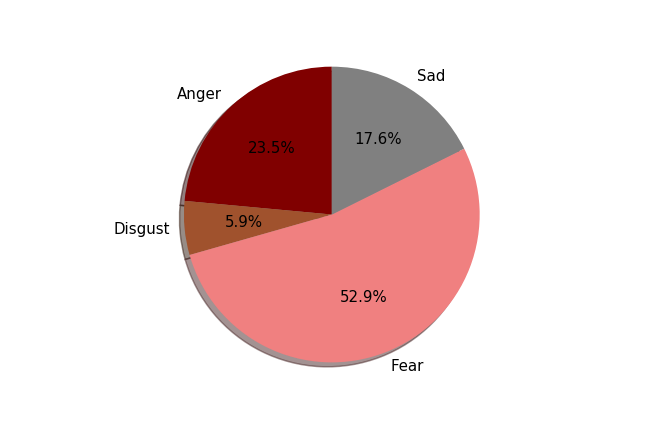

In [83]:
labels = ['Anger', 'Disgust', 'Fear',  'Sad']
counts = list(z.liczba)
colors = ['maroon', 'sienna', 'lightcoral', 'gray']
#sizes = [0.2, 0.2, 0.2, 0.2, 0.2]

fig1, ax1 = plt.subplots()
ax1.pie(counts, labels=labels, autopct='%1.1f%%',colors = colors,
        shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

In [35]:
labels = ['A', 'D', 'F', 'H', 'S']
counts = list(z.liczba)
#sizes = [0.2, 0.2, 0.2, 0.2, 0.2]

for w in dane.speech_rawest[0]:
    sent = df_sp_10.loc[df_sp_10.word==w, 'new_flag']
    #print('Słowo {} ma sentyment {}'.format(w, sent))
    print(sent)
    

0    H
Name: new_flag, dtype: object
1    H
Name: new_flag, dtype: object
2    H
Name: new_flag, dtype: object
3    H
Name: new_flag, dtype: object
4    H
Name: new_flag, dtype: object
5    H
Name: new_flag, dtype: object
1    H
Name: new_flag, dtype: object
6    H
Name: new_flag, dtype: object
7    H
Name: new_flag, dtype: object
8    H
Name: new_flag, dtype: object
9    H
Name: new_flag, dtype: object
10    H
Name: new_flag, dtype: object
11    H
Name: new_flag, dtype: object
12    H
Name: new_flag, dtype: object
13    H
Name: new_flag, dtype: object
14    H
Name: new_flag, dtype: object
Series([], Name: new_flag, dtype: object)
16    H
Name: new_flag, dtype: object
17    H
Name: new_flag, dtype: object
18    F
Name: new_flag, dtype: object
19    H
Name: new_flag, dtype: object
Series([], Name: new_flag, dtype: object)
21    A
Name: new_flag, dtype: object
22    H
Name: new_flag, dtype: object
23    H
Name: new_flag, dtype: object
19    H
Name: new_flag, dtype: object
Series([], Name

56    F
Name: new_flag, dtype: object
147    H
Name: new_flag, dtype: object
148    H
Name: new_flag, dtype: object
149    H
Name: new_flag, dtype: object
148    H
Name: new_flag, dtype: object
150    H
Name: new_flag, dtype: object
151    H
Name: new_flag, dtype: object
Series([], Name: new_flag, dtype: object)
153    H
Name: new_flag, dtype: object
154    H
Name: new_flag, dtype: object
5    H
Name: new_flag, dtype: object
155    H
Name: new_flag, dtype: object
18    F
Name: new_flag, dtype: object
155    H
Name: new_flag, dtype: object
2    H
Name: new_flag, dtype: object
156    H
Name: new_flag, dtype: object
48    H
Name: new_flag, dtype: object
157    H
Name: new_flag, dtype: object
158    H
Name: new_flag, dtype: object
159    H
Name: new_flag, dtype: object
37    H
Name: new_flag, dtype: object
Series([], Name: new_flag, dtype: object)
150    H
Name: new_flag, dtype: object
161    H
Name: new_flag, dtype: object
81    F
Name: new_flag, dtype: object
162    H
Name: new_flag, dty

253    H
Name: new_flag, dtype: object
254    H
Name: new_flag, dtype: object
255    H
Name: new_flag, dtype: object
256    H
Name: new_flag, dtype: object
257    H
Name: new_flag, dtype: object
258    F
Name: new_flag, dtype: object
Series([], Name: new_flag, dtype: object)
260    A
Name: new_flag, dtype: object
261    H
Name: new_flag, dtype: object
262    H
Name: new_flag, dtype: object
263    H
Name: new_flag, dtype: object
250    H
Name: new_flag, dtype: object
251    H
Name: new_flag, dtype: object
264    H
Name: new_flag, dtype: object
265    H
Name: new_flag, dtype: object
266    H
Name: new_flag, dtype: object
258    F
Name: new_flag, dtype: object
119    H
Name: new_flag, dtype: object
Series([], Name: new_flag, dtype: object)
260    A
Name: new_flag, dtype: object
267    H
Name: new_flag, dtype: object
268    H
Name: new_flag, dtype: object
269    H
Name: new_flag, dtype: object
52    H
Name: new_flag, dtype: object
270    H
Name: new_flag, dtype: object
Series([], Name: new

In [ ]:

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Frogs', 'Hogs', 'Dogs', 'Logs'
sizes = [15, 30, 45, 10]
explode = (0, 0.1, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

In [28]:
%matplotlib notebook
import matplotlib.animation as animation

n = 100
x = np.random.randn(n)
# create the function that will do the plotting, where curr is the current frame
def update(curr):
    # check if animation is at the last frame, and if so, stop the animation a
    if curr == n: 
        a.event_source.stop()
    plt.cla()
    bins = np.arange(-4, 4, 0.5)
    plt.hist(x[:curr], bins=bins)
    plt.axis([-4,4,0,30])
    plt.gca().set_title('Sampling the Normal Distribution')
    plt.gca().set_ylabel('Frequency')
    plt.gca().set_xlabel('Value')
    plt.annotate('n = {}'.format(curr), [3,27])

Traceback (most recent call last):
  File "C:\Users\Magda\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py", line 216, in process
    func(*args, **kwargs)
  File "C:\Users\Magda\Anaconda3\lib\site-packages\matplotlib\animation.py", line 1465, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


<IPython.core.display.Javascript object>


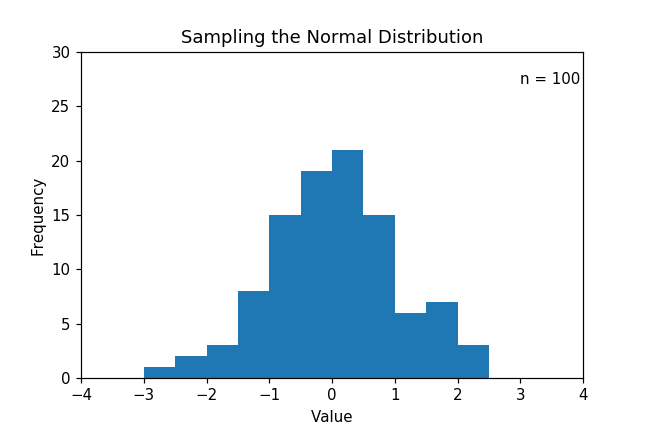

In [32]:
#%matplotlib notebook
#%matplotlib notebook
fig = plt.figure()
a = animation.FuncAnimation(fig, update, interval=50)

In [23]:
plt.cla?